**Task: Predict whether a Simpson episode is 'popular'**

Popularity is defined by "IMDB rating" from simpsons_episodes.csv file.   
The original data are downloaded from https://data.world/data-society/the-simpsons-by-the-data.

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_character = pd.read_csv("D:\Python\data\Simpsons\simpsons_characters.csv")
df_lines = pd.read_csv("D:\Python\data\Simpsons\simpsons_script_lines.csv", low_memory=False)
df_episode = pd.read_csv("D:\Python\data\Simpsons\simpsons_episodes.csv")
df_location = pd.read_csv("D:\Python\data\Simpsons\simpsons_locations.csv")

In [2]:
df_character.head()

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN
2,13,Tattoo Man,tattoo man,NaN
3,16,DOCTOR ZITSOFSKY,doctor zitsofsky,NaN
4,20,Students,students,NaN


In [3]:
df_lines.head(2)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3


In [4]:
df_episode.head(3)

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
0,10,http://static-media.fxx.com/img/FX_Networks_-_...,7.4,1511.0,10,10,1990-03-25,1990,7G10,1,Homer's Night Out,30.3,http://www.simpsonsworld.com/video/275197507879,50816.0
1,12,http://static-media.fxx.com/img/FX_Networks_-_...,8.3,1716.0,12,12,1990-04-29,1990,7G12,1,Krusty Gets Busted,30.4,http://www.simpsonsworld.com/video/288019523914,62561.0
2,14,http://static-media.fxx.com/img/FX_Networks_-_...,8.2,1638.0,1,14,1990-10-11,1990,7F03,2,"Bart Gets an ""F""",33.6,http://www.simpsonsworld.com/video/260539459671,59575.0


In [5]:
df_location.head()

,id,name,normalized_name
0,1,Street,street
1,2,Car,car
2,3,Springfield Elementary School,springfield elementary school
3,4,Auditorium,auditorium
4,5,Simpson Home,simpson home


In [6]:
# Calculate number of lines spoken by each character in each Episode
# Note: Here we also count interjections even there's no words. (i.e. speaking_line=false, spoken_words=Nan etc.)
df_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158271 entries, 0 to 158270
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158271 non-null  int64  
 1   episode_id          158271 non-null  int64  
 2   number              158271 non-null  int64  
 3   raw_text            158271 non-null  object 
 4   timestamp_in_ms     158271 non-null  object 
 5   speaking_line       158271 non-null  object 
 6   character_id        140750 non-null  object 
 7   location_id         157864 non-null  float64
 8   raw_character_text  140749 non-null  object 
 9   raw_location_text   157863 non-null  object 
 10  spoken_words        132112 non-null  object 
 11  normalized_text     132087 non-null  object 
 12  word_count          132112 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 15.7+ MB


In [7]:
# When speaking_line is false, there might be character or no character
df_lines[df_lines.speaking_line=='false'].head()
# When character_id is NaN, it's background/location description from raw_text column

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
8,9557,32,217,(Apartment Building: Ext. apartment building -...,889000,false,NaN,374.0,NaN,Apartment Building,NaN,NaN,NaN
16,9565,32,225,(Springfield Elementary School: EXT. ELEMENTAR...,918000,false,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,NaN
27,9576,32,236,Bart Simpson: (ANGUISHED SCREAM),936000,false,8,3.0,Bart Simpson,Springfield Elementary School,NaN,NaN,NaN
29,75766,263,106,(Moe's Tavern: Int. Moe's - evening),497000,false,NaN,15.0,NaN,Moe's Tavern,NaN,NaN,NaN
35,9583,32,243,(Train Station: int. train station - afternoon),960000,false,NaN,375.0,NaN,Train Station,NaN,NaN,NaN


In [8]:
# drop the rows where character_id is NaN, to focuse on lines spoken by characters
df_lines = df_lines[df_lines.character_id.notna()]
df_lines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140750 entries, 0 to 158270
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  140750 non-null  int64  
 1   episode_id          140750 non-null  int64  
 2   number              140750 non-null  int64  
 3   raw_text            140750 non-null  object 
 4   timestamp_in_ms     140750 non-null  object 
 5   speaking_line       140750 non-null  object 
 6   character_id        140750 non-null  object 
 7   location_id         140343 non-null  float64
 8   raw_character_text  140749 non-null  object 
 9   raw_location_text   140342 non-null  object 
 10  spoken_words        132110 non-null  object 
 11  normalized_text     132085 non-null  object 
 12  word_count          132110 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 15.0+ MB


In [9]:
# fill NaN spoken words column with empty string 
df_lines.spoken_words.fillna('', inplace=True)

# Each row is one line for each character, so we can groupby character_id and episode_id 
# to count how many rows(lines) they have spoken for each episode
character_lines_count_by_episode = df_lines.groupby(['character_id', 'episode_id']).count()['spoken_words'].reset_index()
print(character_lines_count_by_episode.info())
character_lines_count_by_episode.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21288 entries, 0 to 21287
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   character_id  21288 non-null  object
 1   episode_id    21288 non-null  int64 
 2   spoken_words  21288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 499.1+ KB
None


,character_id,episode_id,spoken_words
0,1,1,43
1,1,2,23
2,1,3,15
3,1,4,41
4,1,5,17


In [10]:
# merge this dataset with df_character - character_id is always more reliable than raw_character_text
# For raw text there might be variation in spelling and causing problem when merge
print(df_character.info())

# df_character has id as int data type, and in character_lines_count_by_episode dataframe, character_id is of data type object
# so need to convert them to consistent type before merge
def to_int(x):
    try:
        return int(x)
    except:
        return -999
character_lines_count_by_episode.character_id = character_lines_count_by_episode.character_id.apply(to_int)

# merge 2 datasets
character_lines_count_by_episode = character_lines_count_by_episode.merge(df_character, left_on='character_id', right_on='id', how='left')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6722 non-null   int64 
 1   name             6722 non-null   object
 2   normalized_name  6722 non-null   object
 3   gender           323 non-null    object
dtypes: int64(1), object(3)
memory usage: 210.2+ KB
None


In [11]:
# clean up column names
character_lines_count_by_episode = character_lines_count_by_episode.drop('id', axis=1).sort_values('character_id')
character_lines_count_by_episode = character_lines_count_by_episode.rename(columns={'spoken_words':'lines_count'})

# sort characters by number of lines they have spoken
character_lines_count_by_episode = character_lines_count_by_episode.sort_values('lines_count', ascending=False)
character_lines_count_by_episode.head()

,character_id,episode_id,lines_count,name,normalized_name,gender
6752,2,231,145,Homer Simpson,homer simpson,m
6545,2,24,129,Homer Simpson,homer simpson,m
19145,8,34,122,Bart Simpson,bart simpson,m
6872,2,351,122,Homer Simpson,homer simpson,m
6814,2,293,119,Homer Simpson,homer simpson,m


In [12]:
# characters with gender as NaN are mostly background noise. But we will keep them for now
character_lines_count_by_episode[character_lines_count_by_episode.gender.isna()]

,character_id,episode_id,lines_count,name,normalized_name,gender
16531,5669,465,49,Kurt Hardwick,kurt hardwick,NaN
17041,5996,498,40,Bar Rag,bar rag,NaN
13842,4174,333,30,TEN-YEAR-OLD MARGE,ten-year-old marge,NaN
18024,6666,559,29,MR. LASSEN,mr lassen,NaN
8136,2251,413,28,Donny,donny,NaN
...,...,...,...,...,...,...
17904,658,214,1,Everyone,everyone,NaN
17906,658,283,1,Everyone,everyone,NaN
17907,658,294,1,Everyone,everyone,NaN
17909,658,470,1,Everyone,everyone,NaN


In [13]:
# pivot function to rearrange information
character_lines_count_by_episode = character_lines_count_by_episode.pivot(index=['name'], columns = ['episode_id'])[['lines_count']]
character_lines_count_by_episode = character_lines_count_by_episode['lines_count'].fillna(0.0)
character_lines_count_by_episode

episode_id,1,2,3,4,5,6,7,8,9,10,...,559,560,561,562,563,564,565,566,567,568
name,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""For Dummies"" Author",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Just Stamp the Ticket"" Man",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Mario"" #2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Shorts"" Bart",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alligator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iPod,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
newsstand Operator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# there are a lot of 'noise' information, e.g. "For Dummies" Author probably does not carry much information towards an episode's popularity.
# we need to select features with more consideration - Filter/Select characters by number of lines they have across all episodes
top_n = 300
top_characters = list(character_lines_count_by_episode.sum(axis=1).sort_values(ascending=False)[:top_n].index)
top_characters[:10]

['Homer Simpson',
 'Marge Simpson',
 'Bart Simpson',
 'Lisa Simpson',
 'C. Montgomery Burns',
 'Moe Szyslak',
 'Seymour Skinner',
 'Ned Flanders',
 'Grampa Simpson',
 'Milhouse Van Houten']

In [15]:
character_lines_count_by_episode_filtered = character_lines_count_by_episode[character_lines_count_by_episode.index.isin(top_characters)]
character_lines_count_by_episode_filtered

episode_id,1,2,3,4,5,6,7,8,9,10,...,559,560,561,562,563,564,565,566,567,568
name,,,,,,,,,,,,,,,,,,,,,
10-Year-Old Homer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARTIE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agnes Skinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Akira,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alec Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wayne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Woman,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Women,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# there are only 564 columns, but there are in total 600 episodes based on df_episode,
# because some episodes does not have script record, however, they still have some basic information from df_episode, 
# so we will keep them even they lack character features
print('df_lines.episode_id.unique():', len(df_lines.episode_id.unique()))
print('df_episode:', df_episode.shape)


df_lines.episode_id.unique(): 564
df_episode: (600, 14)


<AxesSubplot: >

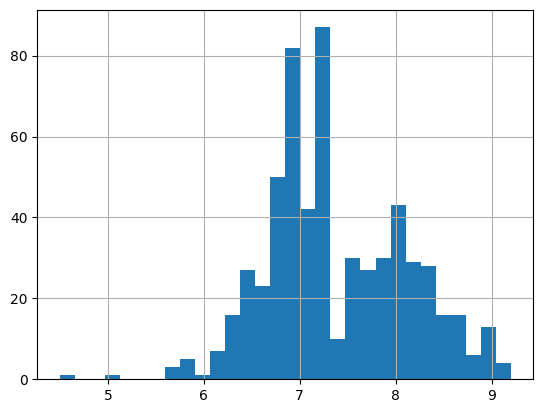

In [17]:
# Episode Dataset
# split the episode into 2 groups: popular/unpopular based on the 'imdb_rating' column

df_episode.imdb_rating.hist(bins=30)

In [21]:
# define the imdb threshold for popular and 'unpopular'
threshold = 7.3

# Create the popularity_class based on threshold
df_episode['popularity_class'] = df_episode['imdb_rating']>=threshold
df_episode['popularity_class'] = df_episode['popularity_class'].astype(int)
# 1 meaning rating over threshold (popular)
# 0 meaning rating below threshold (unpopular)
df_episode['popularity_class'].value_counts()

1    300
0    300
Name: popularity_class, dtype: int64

In [27]:
df_episode[['imdb_rating', 'imdb_votes','number_in_season']].corr()
# imdb_rating and imdb_votes are closely related (0.78), and our popularity class is defined by imdb_rating, 
# so we should remove them from feature columns

,imdb_rating,imdb_votes,number_in_season
imdb_rating,1.000000,0.783829,-0.000065
imdb_votes,0.783829,1.000000,-0.103570
number_in_season,-0.000065,-0.103570,1.000000


In [32]:
related_cols=['number_in_season', 'number_in_series', 'original_air_year','season', 'us_viewers_in_millions','views', 'popularity_class']
df_episode = df_episode[related_cols]
df_episode = df_episode.reset_index().rename(columns={'index':'episode_id'})
df_episode.head()

,episode_id,number_in_season,number_in_series,original_air_year,season,us_viewers_in_millions,views,popularity_class
0,0,10,10,1990,1,30.3,50816.0,1
1,1,12,12,1990,1,30.4,62561.0,1
2,2,1,14,1990,2,33.6,59575.0,1
3,3,4,17,1990,2,26.1,64959.0,1
4,4,6,19,1990,2,25.4,50691.0,1


In [33]:
# combine the information we have
character_lines_with_episode_info = pd.merge(character_lines_count_by_episode_filtered.T, df_episode, on='episode_id', how='outer')
character_lines_with_episode_info

,episode_id,10-Year-Old Homer,ARTIE,Agnes Skinner,Akira,Alec Baldwin,Alex,All,Amber Dempsey,Annie Crawford,...,Women,Workers,Zack,number_in_season,number_in_series,original_air_year,season,us_viewers_in_millions,views,popularity_class
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12,12,1990,1,30.40,62561.0,1
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,14,1990,2,33.60,59575.0,1
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,17,1990,2,26.10,64959.0,1
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6,19,1990,2,25.40,50691.0,1
4,5,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,8,21,1990,2,26.20,57605.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14,500,2012,23,5.77,45226.0,0
596,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16,502,2012,23,4.97,44818.0,1
597,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,511,2012,24,5.65,39687.0,0
598,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12,542,2014,25,2.69,39292.0,0


In [34]:
# Sort the columns by top_characters plus the related columns (the index is episode_id - total 600 episodes)
character_lines_with_episode_info[top_characters+related_cols]

,Homer Simpson,Marge Simpson,Bart Simpson,Lisa Simpson,C. Montgomery Burns,Moe Szyslak,Seymour Skinner,Ned Flanders,Grampa Simpson,Milhouse Van Houten,...,Gary,Maya,CAIN,number_in_season,number_in_series,original_air_year,season,us_viewers_in_millions,views,popularity_class
0,117.0,43.0,51.0,21.0,3.0,2.0,3.0,7.0,2.0,2.0,...,0.0,0.0,0.0,12,12,1990,1,30.40,62561.0,1
1,57.0,23.0,82.0,10.0,0.0,0.0,18.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1,14,1990,2,33.60,59575.0,1
2,59.0,15.0,33.0,11.0,13.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,17,1990,2,26.10,64959.0,1
3,83.0,41.0,43.0,35.0,18.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6,19,1990,2,25.40,50691.0,1
4,33.0,17.0,102.0,28.0,0.0,0.0,6.0,0.0,20.0,5.0,...,0.0,0.0,0.0,8,21,1990,2,26.20,57605.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14,500,2012,23,5.77,45226.0,0
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16,502,2012,23,4.97,44818.0,1
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,511,2012,24,5.65,39687.0,0
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12,542,2014,25,2.69,39292.0,0


In [36]:
y_all = character_lines_with_episode_info['popularity_class']
X_all = character_lines_with_episode_info.drop('popularity_class', axis=1)

y_all.to_csv("D:\Python\data\Simpsons\y_all.csv", index=True)
X_all.to_csv("D:\Python\data\Simpsons\X_all.csv", index=True)